In [2]:
%matplotlib inline
import pandas as pd
import requests
from io import StringIO
import ee

In [3]:

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [5]:
# Tensorflow setup.
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import optimizers
from keras import layers
from keras import callbacks
from keras import backend as K

# used to help transform data
from sklearn import preprocessing
import folium

print(f"Using TensorFlow version {tf.__version__}")


Using TensorFlow version 2.17.0


In [6]:
START_DATE = "1990-07-01"
END_DATE = "2020-07-01"

In [7]:
from datetime import datetime
def calculate_date_range(start_date: str, end_date: str) -> int:
    a = datetime.strptime(start_date, "%Y-%m-%d")
    b = datetime.strptime(end_date, "%Y-%m-%d")
    return (b - a).days + 1

# Example usage
print(calculate_date_range(START_DATE,END_DATE))


10959


In [9]:
siteNumber = "02387500"
usgs_water_data_url = "https://waterdata.usgs.gov/nwis/dv"
params = {
    "site_no": siteNumber,
    "begin_date": START_DATE,
    "end_date": END_DATE,
    "format": "rdb", # default parameter, do not change
    # 00060 - Discharge, cubic feet per second (Mean)
    "parameter_cd": "00060", # Learn more https://waterdata.usgs.gov/nwis/?tab_delimited_format_info
}

response = requests.get(usgs_water_data_url, params=params)

if response.status_code == 200:
    print("Successful Data Request! 🎉")
else:
    print(response.status_code)
    print(response.reason)
    print("Uh-oh...something went wrong.")


Successful Data Request! 🎉


In [10]:
response.text

"# ---------------------------------- WARNING ----------------------------------------\n# Some of the data that you have obtained from this U.S. Geological Survey database\n# may not have received Director's approval. Any such data values are qualified\n# as provisional and are subject to revision. Provisional data are released on the\n# condition that neither the USGS nor the United States Government may be held liable\n# for any damages resulting from its use.\n#\n# Additional info: https://waterdata.usgs.gov/provisional-data-statement/\n#\n# Contact:   gs-w_waterdata_support@usgs.gov\n# retrieved: 2024-09-20 05:06:35 EDT       (vaww01)\n#\n# Data for the following 1 site(s) are contained in this file\n#    USGS 02387500 OOSTANAULA RIVER AT RESACA, GA\n# -----------------------------------------------------------------------------------\n#\n# Data provided for site 02387500\n#            TS   parameter     statistic     Description\n#         37591       00065     00001     Gage heig

In [24]:
header, table = response.text.split("# \n")

In [26]:
print(header)

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://waterdata.usgs.gov/provisional-data-statement/
#
# Contact:   gs-w_waterdata_support@usgs.gov
# retrieved: 2024-09-20 05:06:35 EDT       (vaww01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 02387500 OOSTANAULA RIVER AT RESACA, GA
# -----------------------------------------------------------------------------------
#
# Data provided for site 02387500
#            TS   parameter     statistic     Description
#         37591       00065     00001     Gage height, feet (Maximum)


In [28]:
table

'agency_cd\tsite_no\tdatetime\t37594_00060_00003\t37594_00060_00003_cd\n5s\t15s\t20d\t14n\t10s\nUSGS\t02387500\t1990-07-01\t781\tA\nUSGS\t02387500\t1990-07-02\t1170\tA\nUSGS\t02387500\t1990-07-03\t1300\tA\nUSGS\t02387500\t1990-07-04\t1350\tA\nUSGS\t02387500\t1990-07-05\t1310\tA\nUSGS\t02387500\t1990-07-06\t1270\tA\nUSGS\t02387500\t1990-07-07\t972\tA\nUSGS\t02387500\t1990-07-08\t750\tA\nUSGS\t02387500\t1990-07-09\t776\tA\nUSGS\t02387500\t1990-07-10\t807\tA\nUSGS\t02387500\t1990-07-11\t990\tA\nUSGS\t02387500\t1990-07-12\t1350\tA\nUSGS\t02387500\t1990-07-13\t2190\tA\nUSGS\t02387500\t1990-07-14\t4390\tA\nUSGS\t02387500\t1990-07-15\t4070\tA\nUSGS\t02387500\t1990-07-16\t2590\tA\nUSGS\t02387500\t1990-07-17\t1860\tA\nUSGS\t02387500\t1990-07-18\t1600\tA\nUSGS\t02387500\t1990-07-19\t1510\tA\nUSGS\t02387500\t1990-07-20\t1920\tA\nUSGS\t02387500\t1990-07-21\t2930\tA\nUSGS\t02387500\t1990-07-22\t2300\tA\nUSGS\t02387500\t1990-07-23\t2370\tA\nUSGS\t02387500\t1990-07-24\t2490\tA\nUSGS\t02387500\t1990-0

In [30]:
col_names = ["agency", "site", "datetime", "discharge", "quality"]
df = pd.read_csv(StringIO(table), sep="\t")
df = df.iloc[1:]
df.columns = col_names

print(f"Table dimensions: {df.shape}")
df

Table dimensions: (10959, 5)


,agency,site,datetime,discharge,quality
1,USGS,02387500,1990-07-01,781,A
2,USGS,02387500,1990-07-02,1170,A
3,USGS,02387500,1990-07-03,1300,A
4,USGS,02387500,1990-07-04,1350,A
5,USGS,02387500,1990-07-05,1310,A
...,...,...,...,...,...
10955,USGS,02387500,2020-06-27,2110,A
10956,USGS,02387500,2020-06-28,2070,A
10957,USGS,02387500,2020-06-29,2060,A
10958,USGS,02387500,2020-06-30,2380,A


In [32]:
import pandas as pd

# Filter the DataFrame to keep only the relevant columns, and create a copy to avoid SettingWithCopyWarning
df = df[["datetime", "discharge"]].copy()

# Convert 'discharge' to float and then to m^3/s
df.loc[:, "discharge"] = df["discharge"].astype(float) * 0.0283168

# Set 'datetime' column as the index and convert it to datetime
df.set_index(pd.to_datetime(df["datetime"]), inplace=True)

# Drop the original 'datetime' column
df.drop(columns="datetime", inplace=True)

print(df.head()) 



            discharge
datetime             
1990-07-01  22.115421
1990-07-02  33.130656
1990-07-03   36.81184
1990-07-04   38.22768
1990-07-05  37.095008


In [34]:
# specify where the gauge is located so we can filter the basin by location
gauge_lat, gauge_lon = 34.5775, -84.941917
gauge_geom = ee.Geometry.Point([gauge_lon, gauge_lat])

In [36]:
hydrosheds = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_8")

basin = hydrosheds.filterBounds(gauge_geom)

In [15]:
basinOutline = ee.Image().byte()\
    .paint(featureCollection=basin,
           color=1,
           width=3).getMapId()

map = folium.Map(location=[gauge_lat, gauge_lon], zoom_start=9, height=700)
folium.TileLayer(
    tiles=basinOutline["tile_fetcher"].url_format,
    attr="Google Earth Engine",
    overlay=True,
    name="River Basin",
  ).add_to(map)

folium.Marker([gauge_lat, gauge_lon]).add_to(map)

map.add_child(folium.LayerControl())
map

In [38]:
# specify band names we want
met_data = ["total_precipitation", "minimum_2m_air_temperature", "maximum_2m_air_temperature", "u_component_of_wind_10m", "v_component_of_wind_10m", "surface_pressure"]

# filter the collection by date and select the bands on interest
era5 = ee.ImageCollection("ECMWF/ERA5/DAILY")\
    .filterDate(START_DATE, ee.Date(END_DATE).advance(1, "day"))\
    .select(met_data)

In [40]:
scale = 30000 # 27830 # request scale in meters
lumped_forcings = era5.getRegion(basin, scale).getInfo()

In [42]:
lumped_forcings

[['id',
  'longitude',
  'latitude',
  'time',
  'total_precipitation',
  'minimum_2m_air_temperature',
  'maximum_2m_air_temperature',
  'u_component_of_wind_10m',
  'v_component_of_wind_10m',
  'surface_pressure'],
 ['19900701',
  -85.02554164191271,
  34.360559617571695,
  646790400000,
  0.0023558177053928375,
  296.9841003417969,
  307.6773681640625,
  2.5245327949523926,
  -0.27924832701683044,
  98413.375],
 ['19900702',
  -85.02554164191271,
  34.360559617571695,
  646876800000,
  0.0003052735701203346,
  296.03509521484375,
  307.7501220703125,
  0.29168781638145447,
  -1.1977421045303345,
  98115.875],
 ['19900703',
  -85.02554164191271,
  34.360559617571695,
  646963200000,
  0,
  292.9924621582031,
  305.5553894042969,
  -2.6093521118164062,
  0.7895283102989197,
  98356.84375],
 ['19900704',
  -85.02554164191271,
  34.360559617571695,
  647049600000,
  0,
  293.3012390136719,
  306.82452392578125,
  -0.8895220756530762,
  1.5931140184402466,
  98737.9921875],
 ['19900705',

In [44]:
# columns.
lumped_forcings[0]

['id',
 'longitude',
 'latitude',
 'time',
 'total_precipitation',
 'minimum_2m_air_temperature',
 'maximum_2m_air_temperature',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'surface_pressure']

In [46]:
# sample data
lumped_forcings[1]

['19900701',
 -85.02554164191271,
 34.360559617571695,
 646790400000,
 0.0023558177053928375,
 296.9841003417969,
 307.6773681640625,
 2.5245327949523926,
 -0.27924832701683044,
 98413.375]

In [48]:
forcing_df = pd.DataFrame(lumped_forcings[1:])
forcing_df.columns = lumped_forcings[0]
print(forcing_df.shape)
forcing_df.head()

(10959, 10)


,id,longitude,latitude,time,total_precipitation,minimum_2m_air_temperature,maximum_2m_air_temperature,u_component_of_wind_10m,v_component_of_wind_10m,surface_pressure
0,19900701,-85.025542,34.36056,646790400000,0.002356,296.984100,307.677368,2.524533,-0.279248,98413.375000
1,19900702,-85.025542,34.36056,646876800000,0.000305,296.035095,307.750122,0.291688,-1.197742,98115.875000
2,19900703,-85.025542,34.36056,646963200000,0.000000,292.992462,305.555389,-2.609352,0.789528,98356.843750
3,19900704,-85.025542,34.36056,647049600000,0.000000,293.301239,306.824524,-0.889522,1.593114,98737.992188
4,19900705,-85.025542,34.36056,647136000000,0.000041,293.344757,307.293427,0.738009,0.874210,98685.843750


In [50]:

# Group by 'id' and calculate the mean for specified columns
forcing_df = forcing_df.groupby("id").agg({
    "total_precipitation": "mean",
    "minimum_2m_air_temperature": "mean",
    "maximum_2m_air_temperature": "mean",
    "u_component_of_wind_10m": "mean",
    "v_component_of_wind_10m": "mean",
    "surface_pressure": "mean",
    "time": "mean"
})

# Set 'datetime' as the new index by converting 'time' to datetime format
forcing_df["datetime"] = pd.to_datetime(forcing_df["time"] * 1e6)
forcing_df.set_index("datetime", inplace=True)

# Drop the 'time' column
forcing_df.drop(columns="time", inplace=True)

# Rename the columns
forcing_df.columns = ["precip", "tmin", "tmax", "uwind", "vwind", "psurface"]

# Print the shape and show the first few rows
print(forcing_df.shape)
forcing_df.head()


(10959, 6)


,precip,tmin,tmax,uwind,vwind,psurface
datetime,,,,,,
1990-07-01,0.002356,296.984100,307.677368,2.524533,-0.279248,98413.375000
1990-07-02,0.000305,296.035095,307.750122,0.291688,-1.197742,98115.875000
1990-07-03,0.000000,292.992462,305.555389,-2.609352,0.789528,98356.843750
1990-07-04,0.000000,293.301239,306.824524,-0.889522,1.593114,98737.992188
1990-07-05,0.000041,293.344757,307.293427,0.738009,0.874210,98685.843750


In [52]:
model_df = pd.concat([df, forcing_df], axis=1)
model_df.dropna(inplace=True)

print(model_df.shape)

model_df.head()

(10959, 7)


,discharge,precip,tmin,tmax,uwind,vwind,psurface
datetime,,,,,,,
1990-07-01,22.115421,0.002356,296.984100,307.677368,2.524533,-0.279248,98413.375000
1990-07-02,33.130656,0.000305,296.035095,307.750122,0.291688,-1.197742,98115.875000
1990-07-03,36.81184,0.000000,292.992462,305.555389,-2.609352,0.789528,98356.843750
1990-07-04,38.22768,0.000000,293.301239,306.824524,-0.889522,1.593114,98737.992188
1990-07-05,37.095008,0.000041,293.344757,307.293427,0.738009,0.874210,98685.843750


In [54]:
def lstm_data_prep(data_frame, feature_names, label_names, time_lag=10, pred_period=0, scaling_func=None, pct_train=0.90):
    """
    Prepare data for input into an LSTM model.

    Args:
        data_frame (DataFrame): A pandas DataFrame containing features and labels.
        feature_names (list): List of column names that will be used as input features.
        label_names (list): List of column names that will be used as output labels.

    Kwargs:
        time_lag (int): Time to lag datasets. Default is 10 periods.
        pred_period (int): Time period as forecast outputs. Default is 0 (next day forecast).
        scaling_func (sklearn.preprocessing function): Function to preprocess features.
        pct_train (float): Percent of data to be used for training. Used to prevent scaling on all features.

    Returns:
        X_train (numpy array): Array of training features.
        X_test (numpy array): Array of testing features.
        y_train (numpy array): Array of training labels.
        y_test (numpy array): Array of testing labels.
    """
    # Get features
    X = data_frame[feature_names].values

    # Get the labels
    if pred_period > 0:
        y = data_frame[label_names][time_lag: -pred_period].values
    else:
        y = data_frame[label_names][time_lag:].values

    n_train = int(pct_train * X.shape[0])

    # If a scaling function is provided, scale the data
    if scaling_func is not None:
        scaler = scaling_func.fit(X[:n_train])
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X

    x_shape = [y.shape[0], time_lag, X.shape[1]]
    y_shape = [y.shape[0], pred_period] if pred_period > 0 else [y.shape[0], 1]
    out_X = np.zeros(x_shape)
    out_y = np.zeros(y_shape)

    for i in range(y.shape[0] - pred_period):
        # index tracker for X
        v = time_lag + i if i > 0 else time_lag
        # index tracker for y
        u = pred_period + i if pred_period > 0 else i + 1

        out_X[i, :, :] = X_scaled[i:v, :]
        out_y[i, :] = y[i : u][0] # from (shape, 1) to (shape,)

    n_train = int(pct_train * out_X.shape[0])

    X_train, X_test = out_X[:n_train, :, :], out_X[n_train:, :, :]
    y_train, y_test = out_y[:n_train, :], out_y[n_train:, :]

    return X_train, X_test, y_train, y_test

In [56]:
import numpy as np
time_days = 365
feature_columns = ["precip", "tmin", "tmax", "uwind", "vwind", "psurface"]
label_columns = ["discharge"]
pct_train = 0.80

scaler = preprocessing.RobustScaler()
# scaler = preprocessing.MinMaxScaler()

X_train, X_test, y_train, y_test = lstm_data_prep(model_df, feature_columns, label_columns, time_lag=time_days, scaling_func=scaler, pct_train=pct_train)

In [58]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8475, 365, 6) (8475, 1) (2119, 365, 6) (2119, 1)


In [60]:
def build_model(input_shape, output_shape, nodes=64, optimizer="adam", loss="mse"):
    """
    Build an LSTM model.

    Args:
        input_shape (list or tuple): Input shape for the model, representing [time, features].
        output_shape (int): Output shape for the model, representing [output_shape].

    Kwargs:
        nodes (int): Number of nodes to use in LSTM layers. Default is 64.
        optimizer (str or optimizer): Optimizer to use for the model. Default is Adam optimizer.
        loss (str): Loss function to use for the model. Default is mean squared error (MSE).

    Returns:
        model (keras.Model): Compiled Keras model ready for training.
    """
    inputs = layers.Input(input_shape, name="input_layer")

    x = layers.LSTM(input_shape[1], return_sequences=True, name="lstm_layer")(inputs)

    skip_output = layers.Add()([inputs, x])

    X = layers.LSTM(nodes, return_sequences=False, dropout=0.2)(skip_output)  # recurrent_dropout=0.2

    outputs = layers.Dense(output_shape, activation="linear", name="output_layer")(X)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="lstm_hm")

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["mape", "mae", "mse"])

    return model

In [66]:
import tensorflow.keras.backend as K


def nse_loss(y_true, y_pred):
    """
    Calculate the Nash-Sutcliffe model efficiency coefficient (NSE) as a loss function.

    Args:
        y_true (tf.Tensor): Tensor of true values (observations/labels).
        y_pred (tf.Tensor): Tensor of predicted values from the model.

    Returns:
       tf.Tensor: Inverted NSE value for optimization (lower values are better).
    """
    # Numerator: Sum of squared differences between observed and predicted
    numerator = K.sum(K.square(y_true - y_pred))
    
    # Denominator: Sum of squared differences between observed and the mean of observed values
    denominator = K.sum(K.square(y_true - K.mean(y_true))) + K.epsilon()
    
    # NSE calculation
    nse = 1 - (numerator / denominator)
    
    # Return negative NSE for minimization as a loss function
    return -nse



In [68]:
inshape = time_days, len(feature_columns)
outshape = 1

EPOCHS = 5 #Change the epochs 
STEPS_PER_EPOCH = 20 #May adjust
BATCH_SIZE = X_train.shape[0]//STEPS_PER_EPOCH
print(f"BATCH_SIZE: {BATCH_SIZE}")
VAL_SPLIT = 0.1

# clipping value to avoid gradient going inf
optimizer = optimizers.Adam(learning_rate=0.001, clipvalue=1.0)

BATCH_SIZE: 423


In [70]:
model_nse = build_model(inshape, outshape, optimizer=optimizer, loss=nse_loss)
keras.utils.plot_model(model_nse, "model_nse.png", show_shapes=True)
model_nse.summary()

Model: "lstm_hm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 365, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 365, 6)    │        312 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 365, 6)    │          0 │ input_layer[0][0… │
│                     │                   │            │ lstm_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     18,176 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         65 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,553 (72.47 KB)

 Trainable params: 18,553 (72.47 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
training_nse = model_nse.fit(x=X_train,
                             y=y_train,
                             epochs=EPOCHS,
                             batch_size=BATCH_SIZE,
                             validation_split=VAL_SPLIT)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 772ms/step - loss: 0.9023 - mae: 70.3635 - mape: 99.3254 - mse: 10613.5283 - val_loss: 4.3641 - val_mae: 79.7157 - val_mape: 92.2797 - val_mse: 14370.4072
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 747ms/step - loss: 0.7778 - mae: 68.0539 - mape: 87.8139 - mse: 10742.9502 - val_loss: 3.5703 - val_mae: 74.8286 - val_mape: 77.5899 - val_mse: 13652.5098
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 755ms/step - loss: 0.6575 - mae: 64.4858 - mape: 74.2897 - mse: 10512.7910 - val_loss: 3.1391 - val_mae: 71.6288 - val_mape: 68.7610 - val_mse: 13179.3848
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 760ms/step - loss: 0.6202 - mae: 60.4258 - mape: 66.6092 - mse: 9560.3359 - val_loss: 2.8815 - val_mae: 69.7477 - val_mape: 64.4300 - val_mse: 12893.8965
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 839ms/step - loss: 0.5719 - mae: 59.2109 - mape: 63.2487 - mse: 9612.9277 - val_loss: 2.6946 - val_mae: 68.4687 - val_mape: 62.2752 - val_mse: 12681.8564


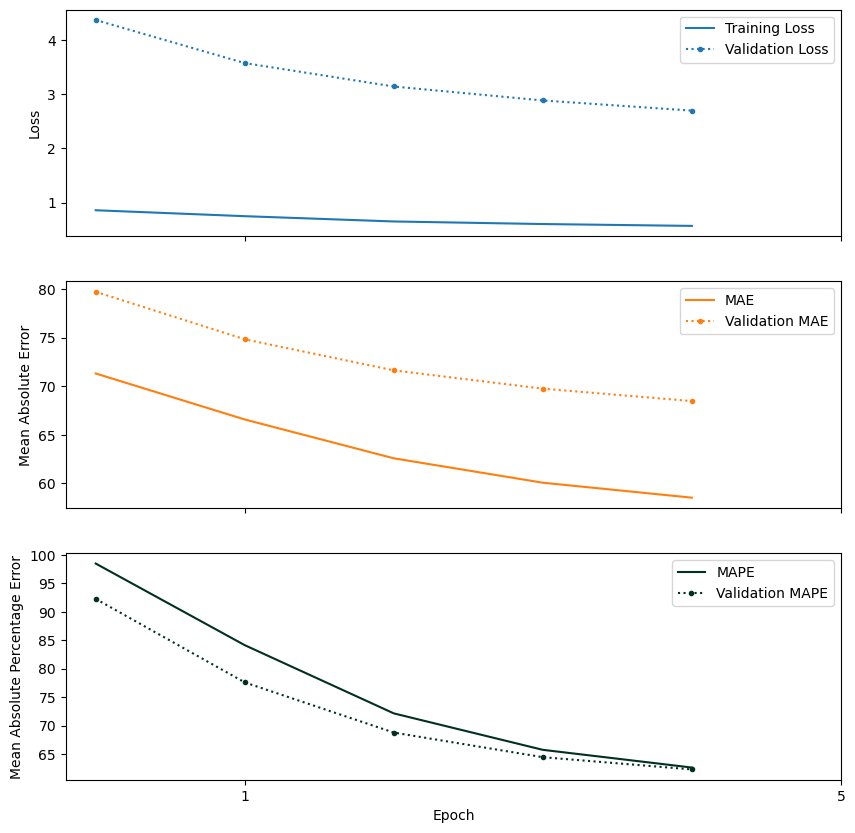

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))

ax[0].plot(training_nse.history["loss"], color="#1f77b4", label="Training Loss")
ax[0].plot(training_nse.history["val_loss"], linestyle=":", marker="o", markersize=3, color="#1f77b4", label="Validation Loss")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(training_nse.history["mae"], color="#ff7f0e", label="MAE")
ax[1].plot(training_nse.history["val_mae"], linestyle=":", marker="o", markersize=3, color="#ff7f0e", label="Validation MAE")
ax[1].legend()
ax[1].set_ylabel("Mean Absolute Error")


ax[2].plot(training_nse.history["mape"], color="#023020", label="MAPE")
ax[2].plot(training_nse.history["val_mape"], linestyle=":", marker="o", markersize=3, color="#023020", label="Validation MAPE")
ax[2].legend()
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Mean Absolute Percentage Error")

ax[2].set_xticks(range(1, len(training_nse.epoch)+1, 4))
ax[2].set_xticklabels(range(1, len(training_nse.epoch)+1, 4))

plt.legend()
plt.show()

In [76]:
from keras.losses import Huber
from keras.optimizers import Adam  # Ensure you're importing the optimizer used

# Recreate optimizer
optimizer = Adam(learning_rate=0.001)  # Or any other optimizer you're using

# Build the model with the fresh optimizer and Huber loss
model_huber = build_model(inshape, outshape, optimizer=optimizer, loss=Huber())

# Plot the model structure
keras.utils.plot_model(model_huber, "model_huber.png", show_shapes=True)

# Fit the model
training_huber = model_huber.fit(x=X_train,
                                 y=y_train,
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 validation_split=VAL_SPLIT)



Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 853ms/step - loss: 71.4613 - mae: 71.9613 - mape: 98.6189 - mse: 11061.2539 - val_loss: 78.2102 - val_mae: 78.7102 - val_mape: 88.9402 - val_mse: 14243.5986
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 768ms/step - loss: 66.8967 - mae: 67.3966 - mape: 84.5540 - mse: 10712.8369 - val_loss: 73.5741 - val_mae: 74.0732 - val_mape: 75.3619 - val_mse: 13547.7373
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 794ms/step - loss: 61.5715 - mae: 62.0688 - mape: 72.1087 - mse: 9600.9004 - val_loss: 70.6631 - val_mae: 71.1594 - val_mape: 67.6083 - val_mse: 13111.7881
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 793ms/step - loss: 59.3968 - mae: 59.8903 - mape: 65.7163 - mse: 9696.4043 - val_loss: 68.9498 - val_mae: 69.4382 - val_mape: 63.8320 - val_mse: 12845.7061
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 753ms/step - loss: 59.4197 - mae: 59.9119 - mape: 62.7412 - mse: 9915.6924 - val_loss: 67.7473 - val_mae: 68.2421 - val_mape: 61.9638 - val_mse: 12643.4082


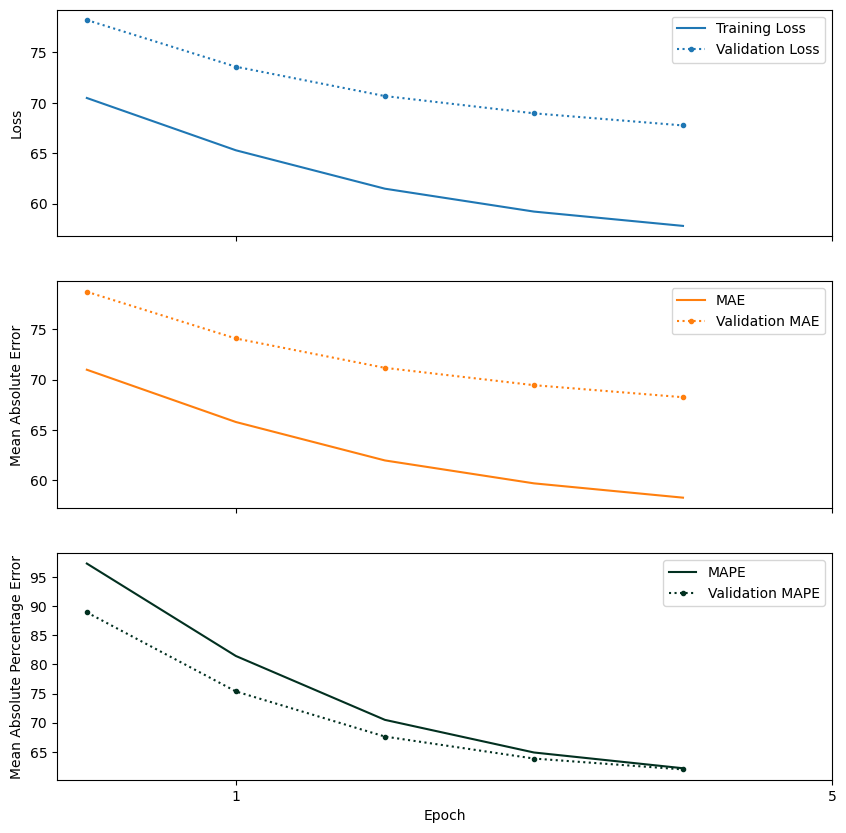

In [78]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))

ax[0].plot(training_huber.history["loss"], color="#1f77b4", label="Training Loss")
ax[0].plot(training_huber.history["val_loss"], linestyle=":", marker="o", markersize=3, color="#1f77b4", label="Validation Loss")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(training_huber.history["mae"], color="#ff7f0e", label="MAE")
ax[1].plot(training_huber.history["val_mae"], linestyle=":", marker="o", markersize=3, color="#ff7f0e", label="Validation MAE")
ax[1].legend()
ax[1].set_ylabel("Mean Absolute Error")


ax[2].plot(training_huber.history["mape"], color="#023020", label="MAPE")
ax[2].plot(training_huber.history["val_mape"], linestyle=":", marker="o", markersize=3, color="#023020", label="Validation MAPE")
ax[2].legend()
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Mean Absolute Percentage Error")

ax[2].set_xticks(range(1, len(training_huber.epoch)+1, 4))
ax[2].set_xticklabels(range(1, len(training_huber.epoch)+1, 4))

plt.legend()
plt.show()

In [80]:
# apply the prediction
y_pred_nse = model_nse.predict(X_test)
y_pred_huber = model_huber.predict(X_test)

# drop the extra dimension for the prediction and test arrays
# this is done for plotting
y_pred_nse = np.squeeze(y_pred_nse)
y_pred_huber = np.squeeze(y_pred_huber)
y_test = np.squeeze(y_test)

67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


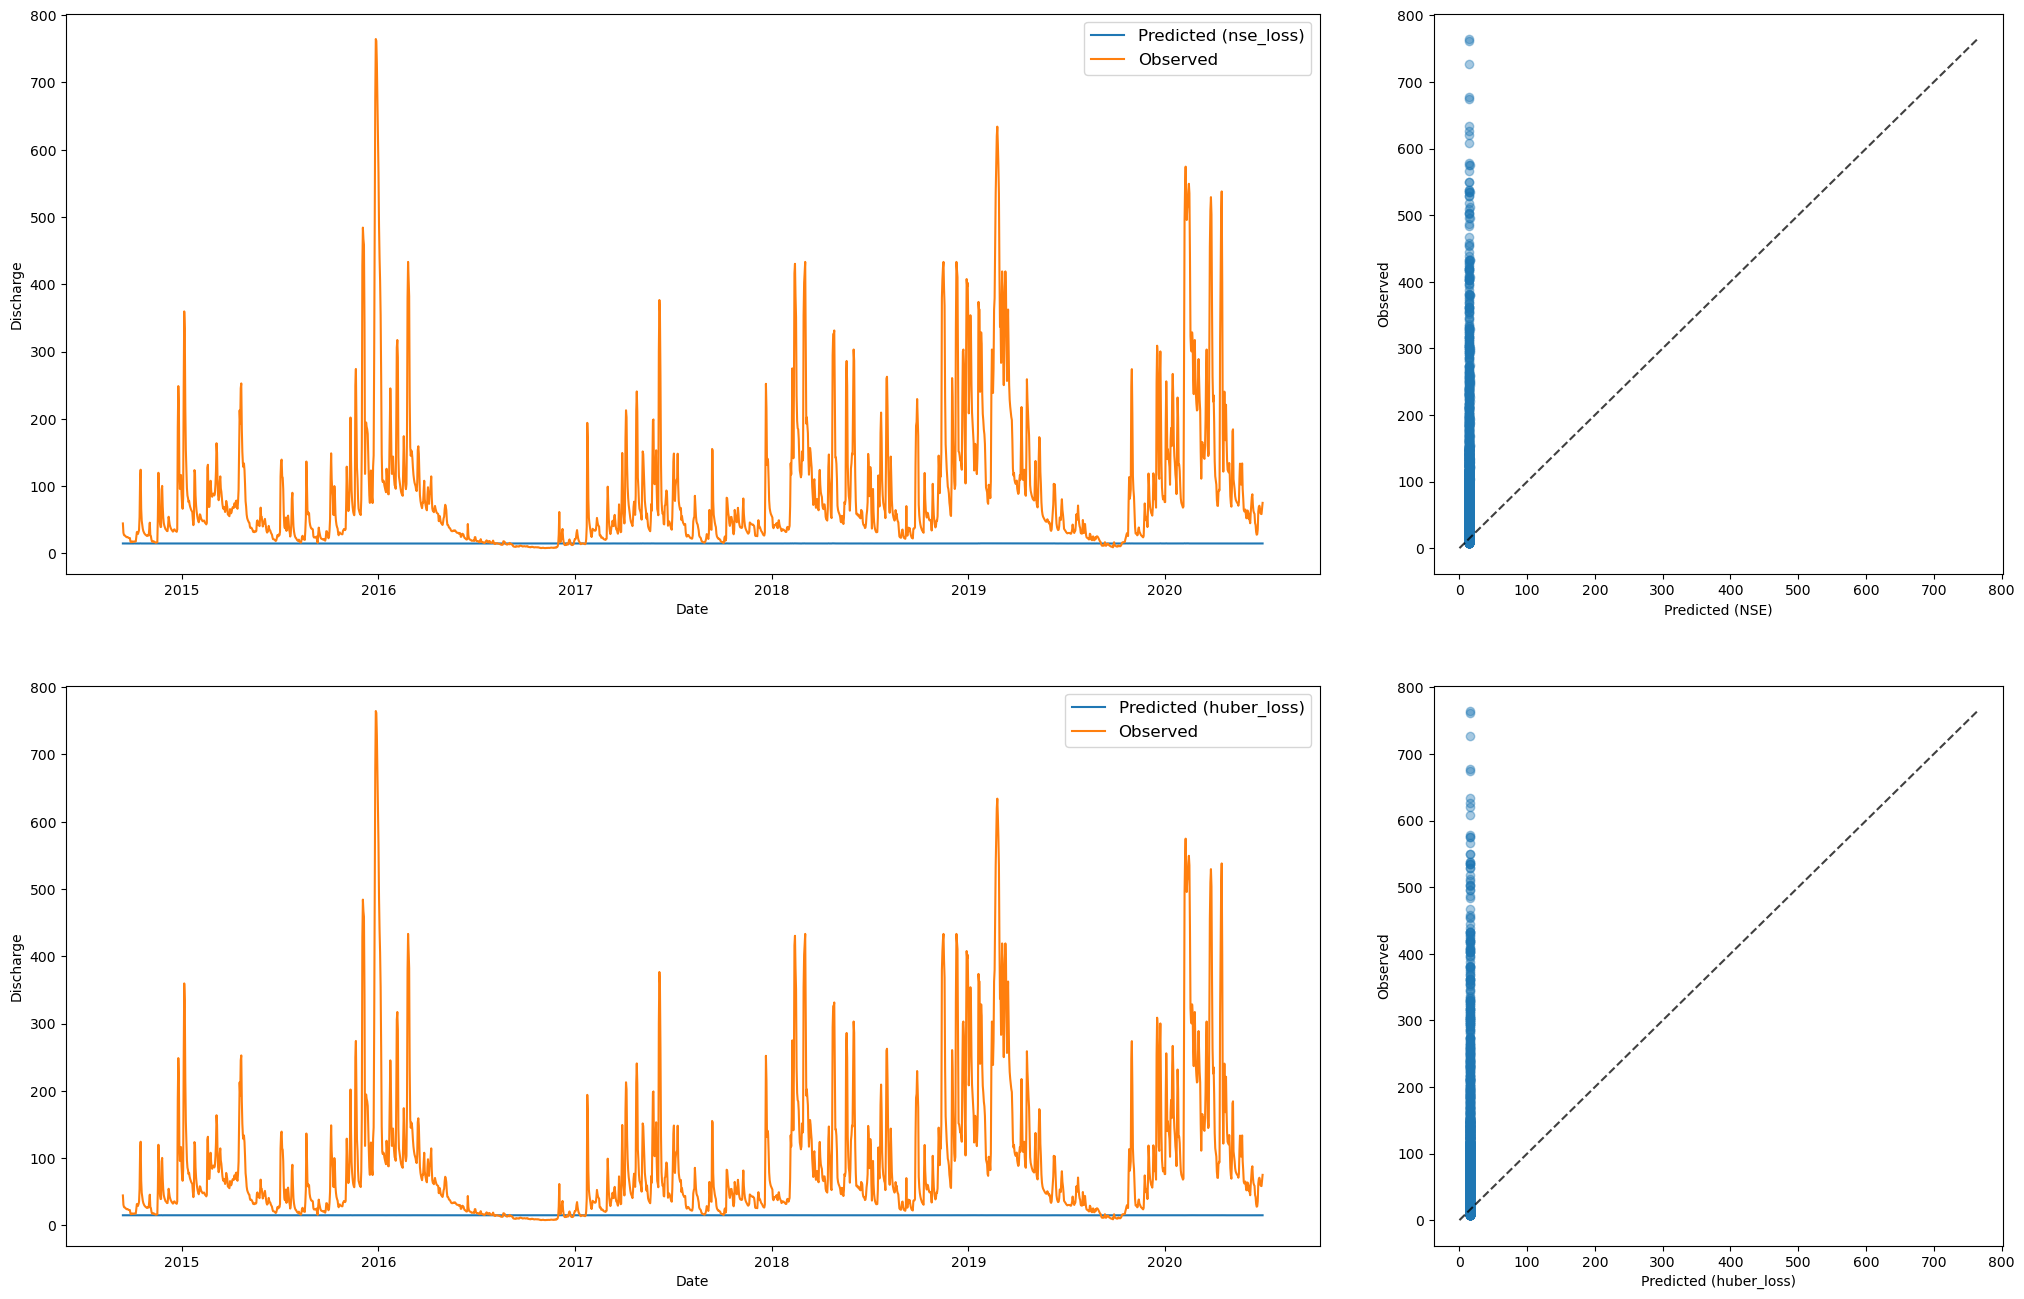

In [84]:


eval_dates = model_df.iloc[X_train.shape[0] + time_days :].index

fig = plt.figure(figsize=(25, 16))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(eval_dates, y_pred_nse, label="Predicted (nse_loss)")
ax1.plot(eval_dates, y_test, label="Observed")
ax1.set_xlabel("Date")
ax1.set_ylabel("Discharge")
ax1.legend(fontsize=12)

ax2 = fig.add_subplot(gs[0, 2:])
ax2.plot(y_pred_nse, y_test, "o", alpha=0.4)
ax2.plot([0,y_test.max()], [0,y_test.max()], "k--", alpha=0.75)
ax2.set_xlabel("Predicted (NSE)")
ax2.set_ylabel("Observed")


ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(eval_dates, y_pred_huber, label="Predicted (huber_loss)")
ax3.plot(eval_dates, y_test, label="Observed")
ax3.set_xlabel("Date")
ax3.set_ylabel("Discharge")
ax3.legend(fontsize=12)

ax4 = fig.add_subplot(gs[1, 2:])
ax4.plot(y_pred_huber, y_test, "o", alpha=0.4)
ax4.plot([0,y_test.max()], [0,y_test.max()], "k--", alpha=0.75)
ax4.set_xlabel("Predicted (huber_loss)")
ax4.set_ylabel("Observed")

plt.show()

In [86]:
feature_columns = ["precip", "tmin", "tmax", "uwind", "vwind", "psurface"]
label_columns = ["discharge"]
pct_train = 0.85

time_lag = 120
pred_period = 5

# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.RobustScaler()


X_train, X_test, y_train, y_test = lstm_data_prep(model_df, feature_columns, label_columns, time_lag=time_lag, pred_period=pred_period, scaling_func=scaler, pct_train=pct_train)

In [88]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9208, 120, 6) (9208, 5) (1626, 120, 6) (1626, 5)


In [110]:
from keras.losses import Huber
inshape = time_lag, len(feature_columns)
outshape = pred_period

EPOCHS = 5
STEPS_PER_EPOCH = 5
BATCH_SIZE = X_train.shape[0]//STEPS_PER_EPOCH
print(f"BATCH_SIZE: {BATCH_SIZE}")
VAL_SPLIT = 0.1

# clipping value to avoid gradient going inf
optimizer = optimizers.Adam(learning_rate=0.001, clipvalue=1.0)

from keras.losses import Huber

# Use the Huber class directly
forecast_model = build_model(inshape, outshape, optimizer=optimizer, loss=Huber())
keras.utils.plot_model(forecast_model, "forecast_model.png", show_shapes=True)
forecast_model.summary()
forecast_model.summary()

BATCH_SIZE: 1841


Model: "lstm_hm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 120, 6)    │        312 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 120, 6)    │          0 │ input_layer[0][0… │
│                     │                   │            │ lstm_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 64)        │     18,176 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │        325 │ lstm_8[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,813 (73.49 KB)

 Trainable params: 18,813 (73.49 KB)

 Non-trainable params: 0 (0.00 B)

Model: "lstm_hm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_layer (LSTM)   │ (None, 120, 6)    │        312 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 120, 6)    │          0 │ input_layer[0][0… │
│                     │                   │            │ lstm_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 64)        │     18,176 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │        325 │ lstm_8[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,813 (73.49 KB)

 Trainable params: 18,813 (73.49 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
forecast_training = forecast_model.fit(x=X_train,
                                       y=y_train,
                                       epochs=EPOCHS,
                                       batch_size=BATCH_SIZE,
                                       validation_split=VAL_SPLIT)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 742ms/step - loss: 73.8690 - mae: 74.3690 - mape: 99.7954 - mse: 12070.1406 - val_loss: 80.7698 - val_mae: 81.2698 - val_mape: 99.5070 - val_mse: 15079.7021
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 701ms/step - loss: 72.9249 - mae: 73.4249 - mape: 99.3010 - mse: 11897.2119 - val_loss: 80.4600 - val_mae: 80.9600 - val_mape: 98.8638 - val_mse: 15024.2119
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 719ms/step - loss: 72.2155 - mae: 72.7155 - mape: 98.3777 - mse: 11576.0107 - val_loss: 79.7953 - val_mae: 80.2953 - val_mape: 97.3241 - val_mse: 14921.0098
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 743ms/step - loss: 71.2451 - mae: 71.7451 - mape: 96.1769 - mse: 11396.1543 - val_loss: 78.9858 - val_mae: 79.4858 - val_mape: 95.3976 - val_mse: 14800.0645
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 748ms/step - loss: 71.1281 - mae: 71.6281 - mape: 93.6013 - mse: 11574.7822 - val_loss: 78.3305 - val_mae: 78.8305 - val_mape: 93.8968 - val_mse: 14697.3389


In [114]:
# run the predictions
forecast = forecast_model.predict(X_test)
 # print the shape (sanity check)
forecast.shape

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


(1626, 5)

In [116]:
eval_dates = model_df.iloc[X_train.shape[0] + time_lag:].index
print(f"start_date: {eval_dates[:1][0]}, end_date: {eval_dates[-1:][0]}")

start_date: 2016-01-14 00:00:00, end_date: 2020-07-01 00:00:00
